## Install npgamma

The following cell uncommented will install npgamma

In [1]:
# !pip install npgamma

## Imports dependencies for example

In [2]:
import dicom
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import urllib.request

from scipy.interpolate import RegularGridInterpolator

from npgamma import calc_gamma_3d

## Load example data

In [3]:
# urllib.request.urlretrieve(
#     "https://raw.githubusercontent.com/"
#     "SimonBiggs/npgamma/master/data_evaluation.dcm", 
#     "data_evaluation.dcm")

# urllib.request.urlretrieve(
#     "https://raw.githubusercontent.com/"
#     "SimonBiggs/npgamma/master/data_reference.dcm", 
#     "data_reference.dcm")

ds_ref = dicom.read_file("data_reference.dcm")
ds_evl = dicom.read_file("data_evaluation.dcm")

## Import the dose from the dicom file

In [4]:
pixel_reference = np.transpose(
    ds_ref.pixel_array, (2, 1, 0))
pixel_evaluation = np.transpose(
    ds_evl.pixel_array, (2, 1, 0))

dose_reference_raw = (
    pixel_reference * ds_ref.DoseGridScaling)
dose_evaluation_raw = (
    pixel_evaluation * ds_evl.DoseGridScaling)

In [5]:
max_ref_dose = np.max(dose_reference_raw)
dose_threshold = 0.03 * max_ref_dose
relevant_dose_threshold = 0.2 * max_ref_dose

## Determine x, y, and z from dicom file

In [6]:
resolution = np.array(
    ds_ref.PixelSpacing).astype(float)

dx = resolution[0]
x_raw = (
    ds_ref.ImagePositionPatient[0] + 
    np.arange(0, ds_ref.Rows * dx, dx))

dy = resolution[1]
y_raw = (
    ds_ref.ImagePositionPatient[1] + 
    np.arange(0, ds_ref.Columns * dy, dy))

In [7]:
z_raw = np.array(
    ds_ref.GridFrameOffsetVector
) + ds_ref.ImagePositionPatient[2]

relevant_slice = (
    np.max(dose_evaluation_raw, axis=(0, 1)) > 
    relevant_dose_threshold)
slice_start = np.max([
        np.where(relevant_slice)[0][0] - 2, 
        0])
slice_end = np.min([
        np.where(relevant_slice)[0][-1] + 2, 
        len(z_raw)])
z_raw = z_raw[slice_start:slice_end]

dose_reference_raw = dose_reference_raw[
    :,:, slice_start:slice_end]
dose_evaluation_raw = dose_evaluation_raw[
    :,:, slice_start:slice_end]

## Interpolate data down to a resolution of 1 mm

In [8]:
dose_reference_interp = RegularGridInterpolator(
    (y_raw, x_raw, z_raw), dose_reference_raw)
dose_evaluation_interp = RegularGridInterpolator(
    (y_raw, x_raw, z_raw), dose_evaluation_raw)

x = np.arange(
    np.min(x_raw) + 1, np.max(x_raw))
y = np.arange(
    np.min(y_raw) + 1, np.max(y_raw))
z = np.arange(
    np.min(z_raw) + 1, np.max(z_raw))

xx_, yy_, zz_ = np.meshgrid(x, y, z)
xx = np.ravel(xx_)
yy = np.ravel(yy_)
zz = np.ravel(zz_)

points = np.swapaxes(np.vstack([yy, xx, zz]), 0, 1)

dose_reference = dose_reference_interp(points)
dose_evaluation = dose_evaluation_interp(points)

In [9]:
dose_reference.shape = (len(y), len(x), len(z))
dose_evaluation.shape = (len(y), len(x), len(z))

## Calculate the 3d gamma index
The step group size parameter is a trade off between ram and computation time. The number represents how many distances to calculate simultaniously. Here I have put in a limit of 500MB of RAM. Certain values of this group size may achieve 2-3x speed up.

In [10]:
memory_usage = dose_evaluation.nbytes * 2
ram_limit = 2**29
step_group_size = ram_limit // memory_usage
step_group_size

4

In [11]:
x_new, y_new, z_new, gamma = calc_gamma_3d(
    x, y, z, dose_evaluation, dose_reference,
    distance_threshold=3, dose_threshold=dose_threshold,
    step_group_size=step_group_size)

## Display relevant gamma

In [12]:
x_start = np.where(x_new[0] == x)[0][0]
x_end = np.where(x_new[-1] == x)[0][0]
y_start = np.where(y_new[0] == y)[0][0]
y_end = np.where(y_new[-1] == y)[0][0]
z_start = np.where(z_new[0] == z)[0][0]
z_end = np.where(z_new[-1] == z)[0][0]

relevant_gamma_ref = dose_evaluation[
    y_start:y_end + 1, 
    x_start:x_end + 1, 
    z_start:z_end + 1
] > relevant_dose_threshold

relevant_gamma = gamma[relevant_gamma_ref]
relevant_less_than_1 = (
    np.sum(relevant_gamma < 1) / len(relevant_gamma))

print("{0:.2f}% of relevant points have gamma < 1".format(
        100 * relevant_less_than_1))

93.97% of relevant points have gamma < 1


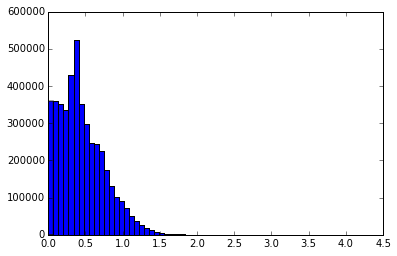

In [13]:
plt.hist(relevant_gamma, 60);

## Draw colour washes representing the relevant slices

Slice = -66.5
50.94% of relevant points have gamma < 1


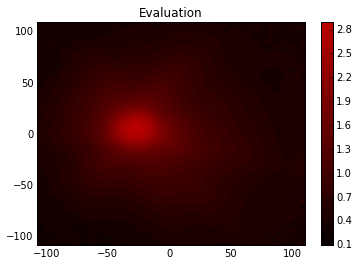

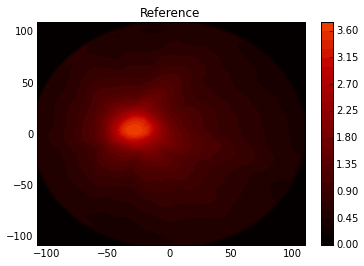

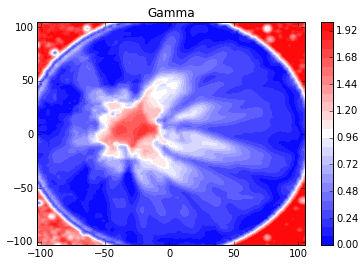



Slice = -46.5
91.61% of relevant points have gamma < 1


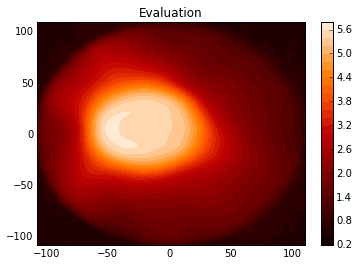

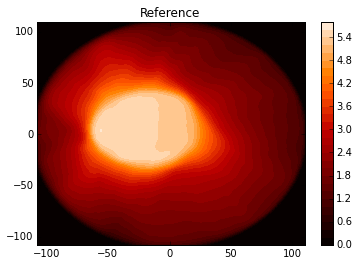

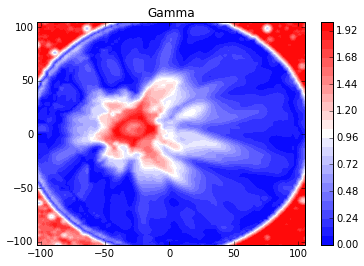



Slice = -26.5
89.55% of relevant points have gamma < 1


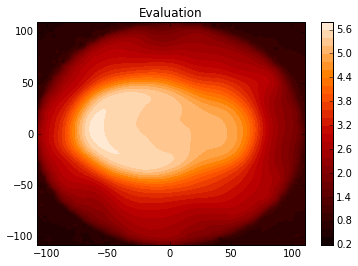

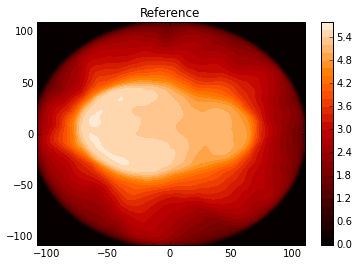

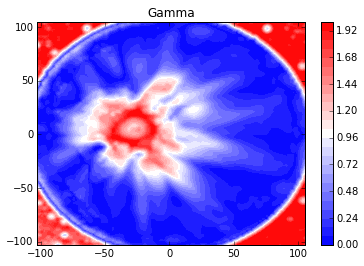



Slice = -6.5
88.64% of relevant points have gamma < 1


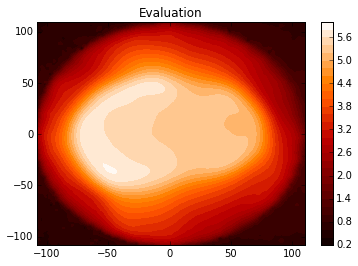

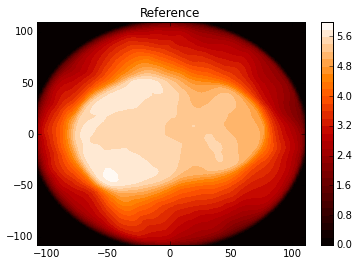

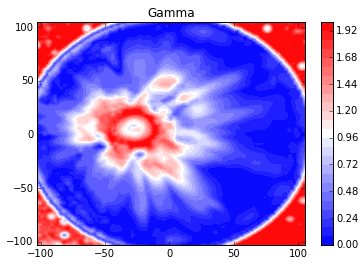



Slice = 13.5
89.45% of relevant points have gamma < 1


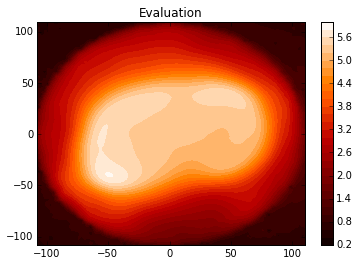

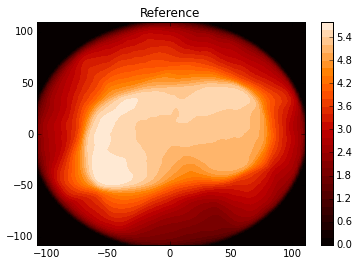

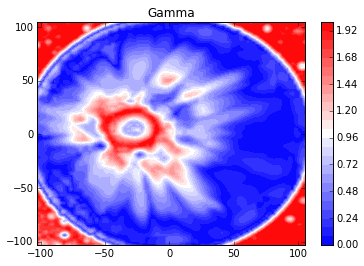



Slice = 33.5
87.67% of relevant points have gamma < 1


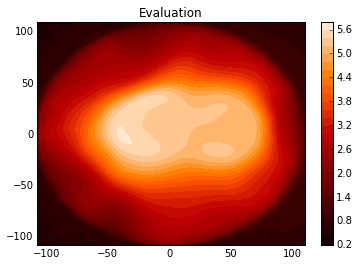

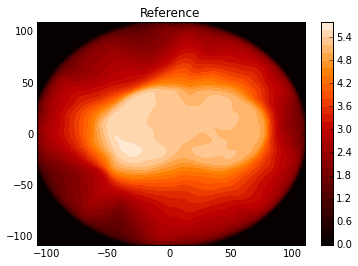

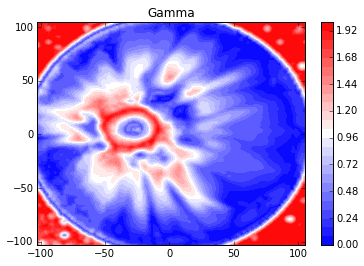



Slice = 53.5
83.69% of relevant points have gamma < 1


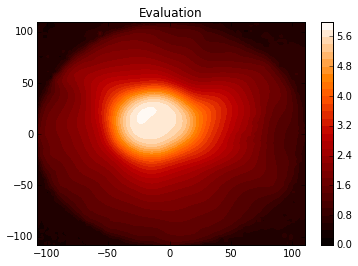

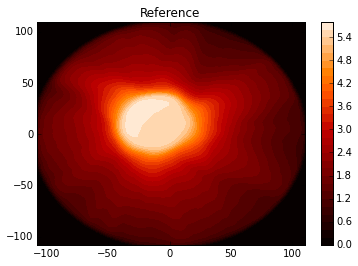

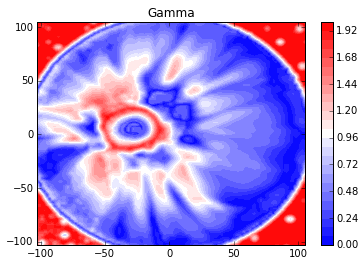

In [14]:
draw_gamma = gamma.copy()
draw_gamma[draw_gamma > 2] = 2

for i, z_i in enumerate(z_new[::20]):
    j = np.where(z_i == z)[0][0]
    print("======================================================================")
    print("Slice = {0}".format(z_i))
    
    relevant_gamma_ref = dose_evaluation[
        y_start:y_end + 1, 
        x_start:x_end + 1, j
    ] > relevant_dose_threshold
    
    relevant_gamma = gamma[relevant_gamma_ref, i]
    relevant_less_than_1 = (
        np.sum(relevant_gamma < 1) / 
        len(relevant_gamma))
    
    print("{0:.2f}% of relevant points have gamma < 1".format(
            100 * relevant_less_than_1))
    
   
    plt.contourf(
        x, y, dose_evaluation[:, :, j], 30, 
        vmin=0, vmax=max_ref_dose, cmap=plt.get_cmap('gist_heat'))
    plt.title("Evaluation")
    plt.colorbar()
    plt.show()
    
    plt.contourf(
        x, y, dose_reference[:, :, j], 30, 
        vmin=0, vmax=max_ref_dose, cmap=plt.get_cmap('gist_heat'))
    plt.title("Reference")  
    plt.colorbar()
    plt.show()
    
    plt.contourf(
        x_new, y_new, draw_gamma[:, :, i], 30, 
        vmin=0, vmax=2, cmap=plt.get_cmap('bwr'))
    plt.title("Gamma")    
    plt.colorbar()  
    plt.show()
    
    print("\n")

## Time how long the calculation takes

In [15]:
%%timeit

x_new, y_new, z_new, gamma = calc_gamma_3d(
    x, y, z, dose_evaluation, dose_reference,
    distance_threshold=3, dose_threshold=dose_threshold,
    step_group_size=step_group_size)

1 loops, best of 3: 1min 22s per loop
